In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# %load ../src/weather_data_clean.py
import pandas as pd

def clean_weather_data(filename):
    """Take ASOS weather data file for Stampede pass and clean it ready for input to model.
    Input: txt file
    Output: pandas dataframe
    """
    data = pd.read_csv(filename)

    # Rename two of the columns
    data.rename(columns={'valid':'date', 'tmpf':'temp'}, inplace=True)

    # Remove the few rows that have a null value for temp
    data = data[~data.temp.eq('M')]

    # Remove spaces from column names
    data.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

    # Only use the standard hourly weather reading at 56 mins past each hour
    mask = data['date'].apply(lambda x: x[-2:] == '56')
    data = data[mask]

    # Create a date series to be used in the clean dataframe
    date = pd.to_datetime(data['date'])

    # Create a temp series to be used in the clean dataframe
    temp = data['temp'].apply(float)

    # Cast the null value M to zero to enable create of the raw precipitation series cast to floats
    data.p01i[data.p01i == 'M'] = 0
    raw_precipitation = data['p01i'].apply(float)

    # Create a precipitation series to be used in the clean dataframe
    precipitation = raw_precipitation.apply(lambda x: True if (x > 0) else False)

    # Convert sky coverage data to clear or cloudy and create an overcast series to be used in the clean dataframe
    sky_elements = ['skyc1', 'skyc2', 'skyc3']
    data.skyc1 = data.skyc1.astype(str)
    data.skyc2 = data.skyc2.astype(str)
    data.skyc3 = data.skyc3.astype(str)
    sky_agg = data[sky_elements].values.tolist()
    sky_reduce = [['overcast' if (('BKN' in element) or ('OVC' in element) or ('VV' in element)) else 'clear'
                    for element in row] for row in sky_agg]
    overcast = pd.Series([True if 'overcast' in row else False for row in sky_reduce])
    overcast.index = date.index

    # Cast the null value 'M' to 10.00 to enable the creation of a poor visibility series
    data.vsby[data.vsby == 'M'] = 10.00
    raw_visibility = data['vsby'].apply(float)
    poor_visibility = pd.Series([True if value < 0.50 else False for value in raw_visibility])
    poor_visibility.index = date.index

    # Cast the null value 'M' to 0 to enable the creation of a windy series
    data.sknt[data.sknt == 'M'] = 0.00
    data.gust[data.gust == 'M'] = 0.00
    wind_speed = data['sknt'].apply(float)
    gust_speed = data['gust'].apply(float)
    wind_df = pd.concat([wind_speed, gust_speed], axis=1)
    # Finally apply the function f to enable the creation of the windy column
    windy = wind_df.apply(f, axis=1)

    """Create the cleaned dataframe by concatenating the date, temp, precipitation, overcast, poor_visibility
    and windy series"""
    df = pd.concat([date, temp, precipitation, overcast, poor_visibility, windy], axis=1)
    df.columns = ['date', 'temp', 'precipitation', 'overcast', 'poor_visibility', 'windy']
    cleaned_df = df[(df['date'] > '2006-12-31') & (df['date'] < '2018-04-03')]
    return cleaned_df

def f(row):
    """Function to be able to create the windy series with windy being true if wind speed is above 10 knots
    or gust speed is above 20 knots"""
    if row['sknt'] >= 10.00:
        val = True
    elif row['gust'] >= 20.00:
        val = True
    else:
        val = False
    return val




In [3]:
weather_df = clean_weather_data('ASOS_stampede_pass/SMP-2.txt')

/Users/leanne/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
# %load ../src/pass_data_clean.py
import pandas as pd

def clean_pass_data(filename):
    """Take Snoqualmie pass closure data file and clean it ready for input to model.
    Input: xlsx file
    Output: Pandas dataframe
    """
    data = pd.read_excel(filename, header=[1])

    #drop unnamed/unnecessary columns
    data.drop(data.columns[[11,12,13,14]], axis=1, inplace=True)

    #drop unnecessary secondary incident columns
    data.drop(data.columns[[1,8]], axis=1, inplace=True)

    #rename 'Incident...' columns to start_time and end_time 
    data.rename(columns={'INCIDENT START TIMES FOR EACH DIRECTION':'start_time'}, inplace=True)
    data.rename(columns={'INCIDENT END TIMES - DIRECTIONAL':'end_time'}, inplace=True)

    #use only dates from 2007-01-01 to match with available weather and traffic volume data
    df = data[(data['start_time'] > '2006-12-31')]

    #rename 'Delay Time Total' to delay
    df.rename(columns={'Delay Time Total':'delay'}, inplace=True)

    #drop row with nan value in delay
    df = df.dropna(subset=['delay'])

    #create a westbound pandas series with True if westbound and false if eastbound
    westbound = pd.Series([True if value == 'WB' else False for value in df.DIRECTION])

    #create a snow pandas series with True if weather description contains sn, false otherwise
    snow = df.WEATHER.str.contains('sn', case=False, na=False, regex=True)

    #create pandas series for start and end times
    start_time = pd.to_datetime(df['start_time'])
    end_time = pd.to_datetime(df['end_time'])

    #ensure that all the pandas series created have the same index
    westbound.index = start_time.index
    snow.index = start_time.index
    end_time.index = start_time.index

    #create cleaned df with the series created
    cleaned_df = pd.concat([start_time, end_time, westbound, snow], axis=1)

    #rename columns
    cleaned_df.rename(columns={0:'westbound', 'WEATHER':'snow'}, inplace=True)

    return cleaned_df



In [5]:
# %load ../src/combine_data.py

pass_closure_df = clean_pass_data('Cumulative_Snoqualmie_Pass_Delay_Closures_1992_2018.xlsx')

def get_pass_closure(date_time):
    """take a date_time and check if it is between the start and end times of a closure event
    input: datetime
    output: boolean
    """
    start_end_times = list(zip(pass_closure_df.start_time, pass_closure_df.end_time))
    for row in start_end_times:
        if row[0] <= date_time <= row[1]:
            return True
    return False

def add_pass_closed(df):
    """take the weather df and add a new column for whether or not the pass is closed at each date_time
    input: pandas dataframe
    output:pandas dataframe
    """
    df['pass_closed'] = df['date'].map(get_pass_closure)
    return df

/Users/leanne/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [6]:
combined_df = add_pass_closed(weather_df)

In [7]:
combined_df.index = combined_df.date

In [8]:
daily_df = combined_df.resample("D").agg({'temp':'mean','precipitation':'max', 'overcast':'max', 'poor_visibility':'max', 'windy':'max', 'pass_closed':'max'})

In [9]:
daily_df.dropna(inplace=True)

In [10]:
daily_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed
date,,,,,,
2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0
2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0
2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0
2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0
2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0
2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0
2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0
2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0
2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0


In [11]:
date_column = pd.Series(daily_df.index)

In [12]:
date_column

0      2006-12-31
1      2007-01-01
2      2007-01-02
3      2007-01-03
4      2007-01-04
5      2007-01-05
6      2007-01-06
7      2007-01-07
8      2007-01-08
9      2007-01-09
10     2007-01-10
11     2007-01-11
12     2007-01-12
13     2007-01-23
14     2007-01-24
15     2007-01-25
16     2007-01-26
17     2007-01-27
18     2007-01-28
19     2007-01-29
20     2007-01-30
21     2007-01-31
22     2007-02-01
23     2007-02-02
24     2007-02-03
25     2007-02-04
26     2007-02-05
27     2007-02-06
28     2007-02-07
29     2007-02-08
          ...    
2840   2018-03-04
2841   2018-03-05
2842   2018-03-06
2843   2018-03-07
2844   2018-03-08
2845   2018-03-09
2846   2018-03-10
2847   2018-03-11
2848   2018-03-12
2849   2018-03-13
2850   2018-03-14
2851   2018-03-15
2852   2018-03-16
2853   2018-03-17
2854   2018-03-18
2855   2018-03-19
2856   2018-03-20
2857   2018-03-21
2858   2018-03-22
2859   2018-03-23
2860   2018-03-24
2861   2018-03-25
2862   2018-03-26
2863   2018-03-27
2864   201

In [13]:
month_day_of_week = pd.DataFrame({"year": date_column.dt.year,
                                  "month": date_column.dt.month, 
                                  "day": date_column.dt.day,
                                  "dayofweek": date_column.dt.dayofweek})

In [14]:
month_day_of_week

,year,month,day,dayofweek
0,2006,12,31,6
1,2007,1,1,0
2,2007,1,2,1
3,2007,1,3,2
4,2007,1,4,3
5,2007,1,5,4
6,2007,1,6,5
7,2007,1,7,6
8,2007,1,8,0
9,2007,1,9,1


In [15]:
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 0] = 'Monday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 1] = 'Tuesday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 2] = 'Wednesday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 3] = 'Thursday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 4] = 'Friday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 5] = 'Saturday'
month_day_of_week.dayofweek[month_day_of_week.dayofweek == 6] = 'Sunday'

In [16]:
month_day_of_week

,year,month,day,dayofweek
0,2006,12,31,Sunday
1,2007,1,1,Monday
2,2007,1,2,Tuesday
3,2007,1,3,Wednesday
4,2007,1,4,Thursday
5,2007,1,5,Friday
6,2007,1,6,Saturday
7,2007,1,7,Sunday
8,2007,1,8,Monday
9,2007,1,9,Tuesday


In [17]:
month_day_of_week = pd.get_dummies(month_day_of_week)

In [18]:
month_day_of_week

,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
0,2006,12,31,0,0,0,1,0,0,0
1,2007,1,1,0,1,0,0,0,0,0
2,2007,1,2,0,0,0,0,0,1,0
3,2007,1,3,0,0,0,0,0,0,1
4,2007,1,4,0,0,0,0,1,0,0
5,2007,1,5,1,0,0,0,0,0,0
6,2007,1,6,0,0,1,0,0,0,0
7,2007,1,7,0,0,0,1,0,0,0
8,2007,1,8,0,1,0,0,0,0,0
9,2007,1,9,0,0,0,0,0,1,0


In [19]:
daily_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed
date,,,,,,
2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0
2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0
2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0
2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0
2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0
2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0
2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0
2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0
2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0


In [20]:
daily_df.reset_index()

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed
0,2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0
1,2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0
2,2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0
3,2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0
4,2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0
5,2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0
6,2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0
7,2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0
8,2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0
9,2007-01-09,35.971250,1.0,1.0,1.0,1.0,0.0


In [23]:
features = pd.concat([daily_df, month_day_of_week], axis=1)

In [22]:
month_day_of_week.index = daily_df.index

In [24]:
features

,temp,precipitation,overcast,poor_visibility,windy,pass_closed,year,month,day,dayofweek_Friday,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday
date,,,,,,,,,,,,,,,,
2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0,2006,12,31,0,0,0,1,0,0,0
2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0,2007,1,1,0,1,0,0,0,0,0
2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0,2007,1,2,0,0,0,0,0,1,0
2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0,2007,1,3,0,0,0,0,0,0,1
2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0,2007,1,4,0,0,0,0,1,0,0
2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0,2007,1,5,1,0,0,0,0,0,0
2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0,2007,1,6,0,0,1,0,0,0,0
2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0,2007,1,7,0,0,0,1,0,0,0
2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0,2007,1,8,0,1,0,0,0,0,0


In [25]:
labels = np.array(features['pass_closed'])

In [26]:
features = features.drop('pass_closed', axis = 1)

In [27]:
feature_list = list(features.columns)

In [28]:
features = np.array(features)

In [29]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [30]:
train_features.shape

(2152, 15)

In [31]:
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

In [32]:
rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [33]:
probs = rf.predict_proba(test_features)

In [34]:
probs

array([[0.943, 0.057],
       [0.906, 0.094],
       [0.979, 0.021],
       ...,
       [0.978, 0.022],
       [0.912, 0.088],
       [0.929, 0.071]])

In [35]:
probs[:,1].max()

0.801

In [36]:
probs[:,1].min()

0.0

In [37]:
probs[:,1].mean()

0.10785376044568244

In [38]:
score = log_loss(test_labels, probs)

In [39]:
score

0.20533262533000335

In [40]:
fpr, tpr, thresholds = roc_curve(test_labels, probs[:,1])

In [41]:
roc_auc = auc(fpr, tpr)

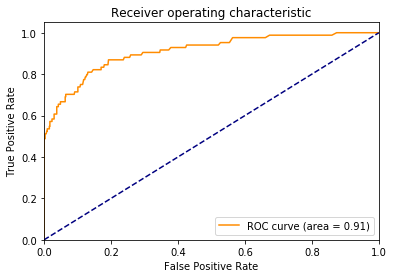

In [42]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [44]:
# Create random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [45]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=400, mi

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.3s


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True, total=   1.7s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=   5.1s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=   5.1s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=   5.0s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=400,

[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, total=   7.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total=   7.8s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total=   8.0s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=   7.2s
[CV] n_estimators=

[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   3.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   3.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   3.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   5.1s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, mi

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   1.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.8s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.8s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   3.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=400, mi

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min


[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   4.7s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   4.7s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   2.4s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   3.5s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   1.4s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   5.3s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True, total=   5.1s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True, total=   5.0s
[CV] n_estim

[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   3.4s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total=   8.1s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   1.6s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   1.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, m

[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total=   7.6s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total=   7.6s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total=   7.7s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   3.1s
[CV] n_estimators=4

[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   2.5s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False, total=   1.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False, total=   1.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=   8.6s
[CV] n_estimators=2

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [46]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 600}

In [47]:
best_random = rf_random.best_estimator_

In [48]:
probs_best_random = best_random.predict_proba(test_features)

In [49]:
probs_best_random

array([[0.9426918 , 0.0573082 ],
       [0.93195304, 0.06804696],
       [0.98864683, 0.01135317],
       ...,
       [0.97380357, 0.02619643],
       [0.92715675, 0.07284325],
       [0.92297354, 0.07702646]])

In [51]:
probs_best_random[:,1].max()

0.857367724867725

In [52]:
probs_best_random[:,1].min()

0.0

In [53]:
probs_best_random[:,1].mean()

0.10809355241632403

In [54]:
score_best_random = log_loss(test_labels, probs_best_random)

In [55]:
score_best_random

0.20532116672672682

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, probs[:,1])